## Libraries

In [1]:
from collections import Counter
from collections import defaultdict
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')  # downloads WordNet data
nltk.download('omw-1.4')  # downloads additional wordnet data for lemmatization
nltk.download('stopwords')  # downloads stopwords (if not already downloaded)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from wordcloud import WordCloud
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from emotion_dataset import EmotionDataset
from loader import loader
from train_model import train_model
from plot_scores import plot_scores
from predict import predict
from predict_on_fly import predict_on_fly
from metrics import compute_metrics, print_metrics, save_metrics

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


## Load and save dataset

In [3]:
train_csv_path = "data/train.csv"
val_csv_path = "data/val.csv"
test_csv_path = "data/test.csv"

train_df, val_df, test_df = loader(train_csv_path, val_csv_path, test_csv_path)

# Task 1: Data Preparation

## Data set

In [4]:
# Print number of examples
print(f"# train sentences: {len(train_df)}")
print(f"# validation sentences: {len(val_df)}")
print(f"# test sentences: {len(test_df)}")

# Print labels names
print(train_df)

# train sentences: 16000
# validation sentences: 2000
# test sentences: 2000
                                                    text  label label_name
0                                i didnt feel humiliated      0    sadness
1      i can go from feeling so hopeless to so damned...      0    sadness
2       im grabbing a minute to post i feel greedy wrong      3      anger
3      i am ever feeling nostalgic about the fireplac...      2       love
4                                   i am feeling grouchy      3      anger
...                                                  ...    ...        ...
15995  i just had a very brief time in the beanbag an...      0    sadness
15996  i am now turning and i feel pathetic that i am...      0    sadness
15997                     i feel strong and good overall      1        joy
15998  i feel like this was such a rude comment and i...      3      anger
15999  i know a lot but i feel so stupid because i ca...      0    sadness

[16000 rows x 3 column

## Step 1: Dataset Preparation

### Label distribution

Number of classes: 6

Training Label Distribution:
label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


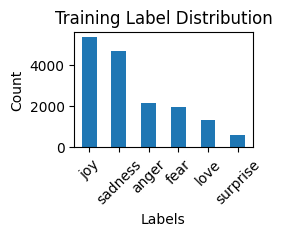

In [5]:
# Create a mapper for label numbers to text labels
num_classes = len(train_df["label"].unique())
print(f"Number of classes: {num_classes}")

# Print the label distribution for training set
train_label_counts = train_df["label_name"].value_counts()
print("\nTraining Label Distribution:")
print(train_label_counts)

# Plot the label distribution
plt.figure(figsize=(2.3, 1.5))
train_label_counts.plot(kind="bar")
plt.title("Training Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Step 2: Tokenizing

### Tokenizer

In [6]:
tokenizer = RegexpTokenizer(r"[a-zA-Z]+|[!?'´`]+") # sequence that don’t match the pattern act as separators.
example_sentence = "This?.is,a:cu123stom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'cu', 'stom', 'tokenization', 'example', '!']


### Tokenize each split

In [7]:
train_tokens = [tokenizer.tokenize(text.lower()) for text in train_df["text"]]
val_tokens = [tokenizer.tokenize(text.lower()) for text in val_df["text"]]
test_tokens = [tokenizer.tokenize(text.lower()) for text in test_df["text"]]

train_vocab = set(token for tokens in train_tokens for token in tokens)

print(f"# words in train vocab: {len(train_vocab)}")

# words in train vocab: 15212


### Word frequency

In [8]:
def get_top_words_per_class(tokens_in, top_n=10):
    tokens_by_class = defaultdict(list)
    for tokens, label in zip(tokens_in, train_df["label_name"]):
        tokens_by_class[label].append(tokens)
    tokens_by_class = dict(tokens_by_class)
    results = []
    for class_label, tokens in tokens_by_class.items():
        flat_tokens = list(chain.from_iterable(tokens))
        most_common = Counter(flat_tokens).most_common(top_n)
        for word, count in most_common:
            results.append({"Class": class_label, "Word": word, "Count": count})
    return pd.DataFrame(results)

print(get_top_words_per_class(train_tokens, top_n=10).to_string(index=False))

   Class    Word  Count
 sadness       i   7635
 sadness    feel   3299
 sadness     and   2692
 sadness      to   2335
 sadness     the   2155
 sadness       a   1656
 sadness feeling   1523
 sadness      of   1422
 sadness    that   1299
 sadness      my   1245
   anger       i   3576
   anger    feel   1459
   anger     and   1258
   anger      to   1162
   anger     the   1109
   anger       a    791
   anger feeling    721
   anger    that    705
   anger      of    630
   anger      my    573
    love       i   2120
    love    feel    929
    love     and    902
    love      to    860
    love     the    780
    love       a    571
    love      of    482
    love    that    460
    love      my    399
    love feeling    378
surprise       i    927
surprise    feel    356
surprise     and    354
surprise     the    335
surprise      to    267
surprise       a    256
surprise    that    212
surprise feeling    209
surprise      of    191
surprise      my    163
    fear       i

### Data cleaning (remove stopwords and stem)

In [9]:
stemmer = nltk.PorterStemmer()
stop_words = set(stopwords.words("english"))

train_tokens = [[stemmer.stem(word) for word in sentence if word not in stop_words] for sentence in train_tokens]
val_tokens = [[stemmer.stem(word) for word in sentence if word not in stop_words] for sentence in val_tokens]
test_tokens = [[stemmer.stem(word) for word in sentence if word not in stop_words] for sentence in test_tokens]

print(get_top_words_per_class(train_tokens, top_n=10).to_string(index=False))

   Class      Word  Count
 sadness      feel   4994
 sadness      like    881
 sadness        im    683
 sadness      know    297
 sadness       get    284
 sadness    realli    276
 sadness      time    271
 sadness      make    245
 sadness      want    244
 sadness        go    235
   anger      feel   2261
   anger      like    391
   anger        im    342
   anger       get    175
   anger      time    140
   anger      want    133
   anger     irrit    128
   anger    realli    124
   anger      know    122
   anger      hate    113
    love      feel   1406
    love      like    366
    love      love    277
    love        im    193
    love   support    103
    love    realli     92
    love      know     89
    love      want     89
    love      time     82
    love      care     82
surprise      feel    601
surprise      amaz    107
surprise      like     92
surprise        im     91
surprise   impress     63
surprise overwhelm     58
surprise     weird     57
surprise   s

### Frequency of words

In [10]:
word_freq = Counter(chain.from_iterable(train_tokens))
pd.DataFrame(word_freq.items(), columns=["Word", "Count"]).sort_values(by="Count", ascending=False).to_csv("results/word_frequencies.csv", index=False)
print(pd.DataFrame(word_freq.most_common(100), columns=["Word", "Count"]).to_string(index=False))

   Word  Count
   feel  16961
   like   3017
     im   2430
    get    981
   time    979
 realli    942
   know    938
   make    935
     go    882
   want    867
   love    805
  littl    736
  think    736
    day    675
  thing    672
  peopl    664
    one    647
  would    646
   even    600
  still    598
    ive    587
   life    555
    way    528
   need    521
    bit    521
 someth    514
   much    496
   dont    482
   work    471
  could    453
    say    450
  start    445
   look    423
    see    419
   back    414
    tri    410
   good    408
 pretti    392
  right    357
  alway    356
   come    351
   help    342
 friend    340
   also    337
   year    336
  today    332
    use    326
   take    317
 around    315
 person    303
   cant    301
   made    296
   hate    285
   well    279
 though    274
  happi    274
  didnt    272
    got    271
  write    270
   live    268
   felt    266
    lot    264
  never    264
thought    263
   hope    261
 someon   

### Remove additional words

In [11]:
additional_words_to_remove = ["feel", "realli", "im", "know", "also", "http"]

train_tokens = [[word for word in sentence if word not in additional_words_to_remove] for sentence in train_tokens]
val_tokens = [[word for word in sentence if word not in additional_words_to_remove] for sentence in val_tokens]
test_tokens = [[word for word in sentence if word not in additional_words_to_remove] for sentence in test_tokens]

print(get_top_words_per_class(train_tokens, top_n=10).to_string(index=False))

   Class      Word  Count
 sadness      like    881
 sadness       get    284
 sadness      time    271
 sadness      make    245
 sadness      want    244
 sadness        go    235
 sadness       day    224
 sadness     thing    221
 sadness       ive    217
 sadness     think    212
   anger      like    391
   anger       get    175
   anger      time    140
   anger      want    133
   anger     irrit    128
   anger      hate    113
   anger     thing    109
   anger      make    108
   anger        go    108
   anger     think    105
    love      like    366
    love      love    277
    love   support    103
    love      want     89
    love      time     82
    love      care     82
    love      long     72
    love       one     70
    love       get     70
    love     sweet     69
surprise      amaz    107
surprise      like     92
surprise   impress     63
surprise overwhelm     58
surprise     weird     57
surprise   surpris     56
surprise    curiou     54
surprise    

### WordCloud

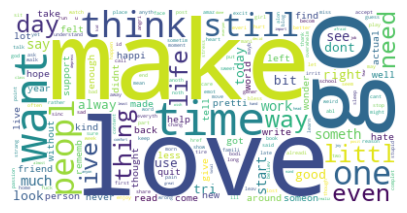

In [12]:
wordcloud = WordCloud(width=400, height=200, background_color="white").generate(" ".join(list(chain.from_iterable(train_tokens))))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentence length distribution

Length range for train: from 1 to 34 words
Mean length for train: 8 words
Standard deviation for train: 5


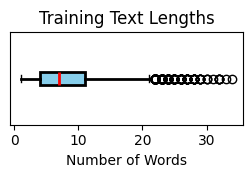

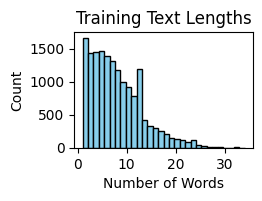

In [13]:
train_lengths = [len(tokens) for tokens in train_tokens]
mean_length = np.mean(train_lengths)
std_dev = np.std(train_lengths)

print(f"Length range for train: from {min(train_lengths)} to {max(train_lengths)} words")
print(f"Mean length for train: {mean_length:.0f} words")
print(f"Standard deviation for train: {std_dev:.0f}")

# Plot boxplot
plt.figure(figsize=(3, 1.2))
plt.boxplot(
    train_lengths,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", linewidth=2), # larger, colored box
    whiskerprops=dict(linewidth=2),  # Thicker whiskers
    medianprops=dict(color="red", linewidth=2), # highlight the median
)
plt.title("Training Text Lengths")
plt.xlabel("Number of Words")
plt.yticks([])
plt.show()

# Plot distribution of lengths
plt.figure(figsize=(2.3, 1.5))
plt.hist(train_lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("Training Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

### Set max and min length

In [14]:
# Set max length for the model. If sentence is longer, truncate it. If shorter, pad it.
# Set min length to remove very short sentences from the training set.
max_length = 10
min_length = 3

train_labels = train_df["label"].tolist()
val_labels = val_df["label"].tolist()

train_tokens, train_labels = zip(
    *[
        (tokens, label)
        for tokens, label in zip(train_tokens, train_labels)
        if len(tokens) >= min_length
    ]
)

# Convert back to lists
train_tokens = list(train_tokens)
train_labels = list(train_labels)

## Step 3: Build a vocabulary

In [15]:
vocab = {"<PAD>": 0, "<UNK>": 1}
for tokens in train_tokens:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

reverse_vocab = {v: k for k, v in vocab.items()}

Vocabulary size: 10336


## Step 4: Encode all texts with the vocabulary

In [16]:
def encode_text(tokens): # i.e. words to integers
    return [vocab[token] if token in vocab else 1 for token in tokens]

train_encoded = [encode_text(tokens) for tokens in train_tokens]
val_encoded = [encode_text(tokens) for tokens in val_tokens]
test_encoded = [encode_text(tokens) for tokens in test_tokens]

## Step 5: Maximum sequence length

In [17]:
def pad_sequence(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

train_padded = [pad_sequence(sequence) for sequence in train_encoded]
val_padded = [pad_sequence(sequence) for sequence in val_encoded]
test_padded = [pad_sequence(sequence) for sequence in test_encoded]

# Task 2: RNN model

In [18]:
batch_size = 16

train_dataset = EmotionDataset(train_padded, train_labels)
val_dataset = EmotionDataset(val_padded, val_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

label_map = {label: name for label, name in enumerate(train_df["label_name"].unique())}

In [19]:
class RNN_model(nn.Module):
    def __init__(self, type, vocab_size, embedding_dim, hidden_size, num_classes, padding_idx=0, num_layers=1, dropout_rnn=0, dropout_fc=0):
        super(RNN_model, self).__init__()
        # embedding_dim: size of each embedding vector
        # hidden_size: number of features in the hidden state
        # num_layers: number of recurrent layers
        # bias: introduces a bias
        # batch_first: input and output tensors are provided as (batch, seq, feature)
        # dropout: if non-zero, introduces a dropout layer on the outputs of each RNN layer except the last layer

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=padding_idx)
        if type == "RNN":
            self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout_rnn, nonlinearity="tanh")
        elif type == "GRU":
            self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout_rnn)
        elif type == "LSTM":
            self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bias=True, batch_first=True, dropout=dropout_rnn)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout_fc)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # extract last hidden state for each sequence
        x = self.dropout(x) # apply dropout to the last hidden state
        x = self.fc(x) # pass last hidden state through the fully connected layer
        return x


In [ ]:
import itertools
import json

def grid_search(vocab_size, num_classes, train_loader, val_loader, label_map, device):
    param_grid = {
        "type": ["RNN", "GRU", "LSTM"],
        "embedding_dim": [25, 50, 100, 200],
        "hidden_size": [8, 16, 32, 64, 128, 256],
        "num_layers": [1, 2],
        "dropout_rnn": [0.0, 0.3, 0.5, 0.7],
        "dropout_fc": [0.0, 0.3, 0.5, 0.7],
        "learning_rate": [0.001, 0.0003, 0.0001],
        "optimizer_type": ["Adam", "AdamW"],
        "reg_lambda": [0.0, 0.01, 0.001, 0.0001],
    }

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    configs = [dict(zip(keys, v)) for v in itertools.product(*values)]
    total_configs = len(configs)

    results_list = []
    for i, config in enumerate(configs):
        label = f"model_{i}"
        print(f"Training model: {label} (no. {i+1}/{total_configs})")
        
        # Initialize the model
        model = RNN_model(
            type=config["type"],
            vocab_size=vocab_size,
            embedding_dim=config["embedding_dim"],
            hidden_size=config["hidden_size"],
            num_classes=num_classes,
            num_layers=config["num_layers"],
            dropout_rnn=config["dropout_rnn"],
            dropout_fc=config["dropout_fc"],
        )

        # Train the model
        results = train_model(
            label=label,
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            label_map=label_map,
            device=device,
            optimizer_type=config["optimizer_type"],
            learning_rate=config["learning_rate"],
            reg_type="L2",
            reg_lambda=config["reg_lambda"],
            num_epochs=30,
        )

        # Add results to the list
        results["config"] = config  # Save the config for reference
        results_list.append(results)

    # Save results to a JSON file for later analysis
    with open("grid_search_results.json", "w") as f:
        json.dump(results_list, f, indent=4)

    return results_list

results_list = grid_search(vocab_size, num_classes, train_loader, val_loader, label_map, device)

Training model: model_0 (6 configs left) with config: {'type': 'RNN', 'embedding_dim': 25, 'hidden_size': 16, 'num_layers': 1, 'dropout_rnn': 0.3, 'dropout_fc': 0.3, 'learning_rate': 0.001, 'optimizer_type': 'Adam', 'reg_lambda': 0.0}


c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/2 (7s) | Train: loss 1.622, acc 31.00%, f1 24.74% | Val: loss 1.5806, acc 34.85%, f1 21.78%
Epoch 2/2 (9s) | Train: loss 1.5847, acc 33.24%, f1 23.64% | Val: loss 1.5776, acc 33.65%, f1 24.06%
Total Training Time: 16s

accuracy: 0.3365
f1: 0.2406
precision: 0.2154
recall: 0.3365
classification report:
              precision    recall  f1-score   support

     sadness       0.25      0.19      0.22       550
       anger       0.36      0.80      0.50       704
        love       0.00      0.00      0.00       178
    surprise       0.00      0.00      0.00       275
        fear       0.17      0.03      0.05       212
         joy       0.00      0.00      0.00        81

    accuracy                           0.34      2000
   macro avg       0.13      0.17      0.13      2000
weighted avg       0.22      0.34      0.24      2000

confusion matrix:
[104, 435, 2, 0, 8, 1]
[132, 563, 1, 0, 8, 0]
[56, 115, 0, 0, 7, 0]
[55, 215, 0, 0, 5, 0]
[48, 158, 0, 0, 6, 0]
[19, 60, 1, 0, 1

c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/2 (10s) | Train: loss 1.6019, acc 32.47%, f1 23.84% | Val: loss 1.5553, acc 35.95%, f1 23.60%
Epoch 2/2 (11s) | Train: loss 1.4653, acc 38.96%, f1 32.32% | Val: loss 1.3588, acc 44.00%, f1 38.58%
Total Training Time: 21s

accuracy: 0.44
f1: 0.3858
precision: 0.387
recall: 0.44
classification report:
              precision    recall  f1-score   support

     sadness       0.33      0.41      0.37       550
       anger       0.57      0.77      0.66       704
        love       0.00      0.00      0.00       178
    surprise       0.30      0.39      0.34       275
        fear       0.30      0.03      0.06       212
         joy       0.50      0.01      0.02        81

    accuracy                           0.44      2000
   macro avg       0.34      0.27      0.24      2000
weighted avg       0.39      0.44      0.39      2000

confusion matrix:
[227, 270, 0, 50, 3, 0]
[142, 539, 0, 21, 2, 0]
[90, 56, 0, 29, 3, 0]
[123, 41, 0, 106, 5, 0]
[89, 26, 0, 89, 7, 1]
[15, 9, 0, 53,

c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/2 (9s) | Train: loss 1.6014, acc 33.06%, f1 23.67% | Val: loss 1.5651, acc 35.15%, f1 19.16%
Epoch 2/2 (10s) | Train: loss 1.4786, acc 39.77%, f1 30.99% | Val: loss 1.4051, acc 46.25%, f1 37.88%
Total Training Time: 19s

accuracy: 0.4625
f1: 0.3788
precision: 0.3306
recall: 0.4625
classification report:
              precision    recall  f1-score   support

     sadness       0.39      0.60      0.47       550
       anger       0.54      0.80      0.64       704
        love       0.00      0.00      0.00       178
    surprise       0.00      0.00      0.00       275
        fear       0.32      0.16      0.21       212
         joy       0.00      0.00      0.00        81

    accuracy                           0.46      2000
   macro avg       0.21      0.26      0.22      2000
weighted avg       0.33      0.46      0.38      2000

confusion matrix:
[330, 208, 0, 0, 12, 0]
[139, 561, 0, 1, 3, 0]
[78, 88, 0, 0, 12, 0]
[159, 82, 0, 0, 34, 0]
[111, 65, 0, 2, 34, 0]
[37, 32, 0,

In [21]:
predict_on_fly(
    model=model,
    tokenizer=tokenizer,
    vocab=vocab,
    device=device,
    label_map=label_map,
    max_length=max_length
)

NameError: name 'model' is not defined

# Task 3: Transformer model

# Task 4: Analysis

In [ ]:
test_labels = test_df["label"].tolist()
test_dataset = EmotionDataset(test_padded, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

predict(label, model, device, test_loader, label_map, reverse_vocab)

accuracy: 0.38
f1: 0.2998
precision: 0.2785
recall: 0.38
classification report:
              precision    recall  f1-score   support

     sadness       0.30      0.29      0.29       581
       anger       0.43      0.81      0.56       695
        love       0.00      0.00      0.00       159
    surprise       0.00      0.00      0.00       275
        fear       0.24      0.13      0.17       224
         joy       0.50      0.02      0.03        66

    accuracy                           0.38      2000
   macro avg       0.24      0.21      0.18      2000
weighted avg       0.28      0.38      0.30      2000

confusion matrix:
[166, 399, 0, 0, 16, 0]
[117, 563, 0, 0, 15, 0]
[52, 89, 0, 0, 18, 0]
[116, 141, 0, 0, 18, 0]
[93, 99, 1, 0, 30, 1]
[17, 19, 0, 0, 29, 1]



# Task 5: Pre-trained model (transfer learning)

In [ ]:
model_name = "roberta-base"
num_epochs = 10
learning_rate = 3e-5

def pretrained_evaluation(predictions):
    preds = predictions.predictions.argmax(-1) # get predicted labels
    labels = predictions.label_ids
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

def preprocess_function(texts, labels, tokenizer, max_length):
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "label": labels
    }

# Load pre-trained tokenizer
tokenizer_pretrained = AutoTokenizer.from_pretrained(model_name)

# Preprocess train and validation datasets
train_encodings = preprocess_function(train_df["text"].tolist(), train_labels, tokenizer_pretrained, max_length)
val_encodings = preprocess_function(val_df["text"].tolist(), val_labels, tokenizer_pretrained, max_length)

# Convert to Hugging Face Dataset
train_data = Dataset.from_dict(train_encodings)
val_data = Dataset.from_dict(val_encodings)

# Set format for PyTorch
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# Training arguments
training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch", # evaluate at end of each epoch
    save_strategy="epoch", # save checkpoints after every epoch
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True, # load best model at end of training
    metric_for_best_model="accuracy",  # specify metric to monitor
    save_total_limit=1, # keep only best checkpoint
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=pretrained_evaluation, # compute metrics during evaluation
)

# Train model
trainer.train()

# Evaluate best model
best_results = trainer.evaluate()
print(f"Best Model Evaluation Results:\n {best_results}")

# Save best fine-tuned model
trainer.save_model(f"models/{model_name}")
tokenizer_pretrained.save_pretrained(f"models/{model_name}")

c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\henri\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ArrowInvalid: Column 2 named label expected length 16000 but got length 14331

In [ ]:
# Load trained tokenizer and model
tokenizer_new = AutoTokenizer.from_pretrained(f"models/{model_name}")
model_new = AutoModelForSequenceClassification.from_pretrained(f"models/{model_name}", num_labels=num_classes)

# Preprocess test data
test_encodings = preprocess_function(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer_new, max_length)

# Convert to Hugging Face Dataset
test_dataset = Dataset.from_dict(test_encodings)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define Trainer (ensure it uses the pre-trained model)
trainer = Trainer(model=model_new)

# Make predictions using the Trainer
predictions = trainer.predict(test_dataset)

# Extract logits and compute predicted labels
logits = torch.tensor(predictions.predictions) # convert logits to a PyTorch tensor
predicted_labels = torch.argmax(logits, dim=1).numpy() # convert to numpy array for sklearn metrics

# Evaluate predictions
# label mapping from integer to text labels
metrics = compute_metrics(test_df["label"], predicted_labels, label_map.values())
print_metrics(metrics)
save_metrics(model_name, metrics)

100%|██████████| 250/250 [00:02<00:00, 88.11it/s]

accuracy: 0.8605
f1: 0.8612
precision: 0.8639
recall: 0.8605
classification report:
              precision    recall  f1-score   support

     sadness       0.88      0.91      0.90       581
       anger       0.89      0.87      0.88       695
        love       0.72      0.77      0.75       159
    surprise       0.91      0.83      0.87       275
        fear       0.84      0.79      0.82       224
         joy       0.65      0.85      0.74        66

    accuracy                           0.86      2000
   macro avg       0.82      0.84      0.82      2000
weighted avg       0.86      0.86      0.86      2000

confusion matrix:
[531, 22, 2, 10, 16, 0]
[26, 605, 43, 7, 7, 7]
[10, 21, 123, 3, 1, 1]
[19, 18, 1, 229, 8, 0]
[13, 7, 1, 4, 177, 22]
[4, 4, 1, 0, 1, 56]

